### Important packages

In [1]:
# General packages
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame 
import h5py
import seaborn as sns
import tensorflow as tf

# Numerical packages
import matplotlib
import sklearn
import itertools
from tqdm import tqdm
from scipy import stats, integrate
from scipy.optimize import curve_fit
import scipy.constants as const
from numpy.linalg import inv

# Import KDE
from sklearn.neighbors import KernelDensity

# MCMC
import emcee

# Splines
from scipy.interpolate import interp1d, BSpline, PchipInterpolator
#from csaps import csaps

# Nested sampling
import nestle

# Boosted decision tree packages
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb 
import xgboost as xgb 
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import mean_squared_error
import shap

# Neural network
from keras.models import Sequential
from keras.layers import Dense
import keras
from sklearn.inspection import permutation_importance
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

#import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Random Forets
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score # for cross-validation


# Baysian optimization 
from bayes_opt import BayesianOptimization


# Random search
from sklearn.model_selection import RandomizedSearchCV, KFold

# Data preprocessing 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from datetime import datetime 
import time

# Fit og plot packages
from iminuit import Minuit
# sys.path.append('C:/Users/marti/Google Drev/Uni/Pyhton/External_Functions')
# from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
# from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

### Pretty plotting routines

In [2]:
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    #plt.rcParams['axes.formatter.limits'] = (-1,3)
    #plt.rcParams['axes.linewidth'] = 2.25
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)

### Import data 

In [3]:
data_ash = np.load('data_codingset_ash.npz') # label 0
data_pollen = np.load('data_codingset_pollen.npz') # label 1
data_dust = np.load('data_codingset_dust.npz') # label 2

data = np.concatenate((data_ash['data_ash'],data_pollen['data_pollen'],data_dust['data_dust']))
labels = np.concatenate((data_ash['label'],data_pollen['label'],data_dust['label']), axis=1)[0]
labels, data

(array([0, 0, 0, ..., 2, 2, 2]),
 array([[[121, 121, 121, ..., 122, 122, 122],
         [121, 121, 121, ..., 122, 122, 122],
         [121, 121, 121, ..., 122, 122, 122],
         ...,
         [128, 128, 128, ..., 125, 125, 125],
         [128, 128, 128, ..., 125, 125, 125],
         [128, 128, 128, ..., 125, 125, 125]],
 
        [[147, 147, 147, ..., 122, 122, 122],
         [147, 147, 147, ..., 122, 122, 122],
         [147, 147, 147, ..., 122, 122, 122],
         ...,
         [134, 134, 134, ..., 139, 139, 139],
         [134, 134, 134, ..., 139, 139, 139],
         [134, 134, 134, ..., 139, 139, 139]],
 
        [[120, 120, 120, ..., 122, 122, 122],
         [120, 120, 120, ..., 122, 122, 122],
         [120, 120, 120, ..., 122, 122, 122],
         ...,
         [123, 123, 123, ..., 120, 120, 120],
         [123, 123, 123, ..., 120, 120, 120],
         [123, 123, 123, ..., 120, 120, 120]],
 
        ...,
 
        [[124, 124, 124, ..., 123, 123, 123],
         [124, 124, 124, ..

### Scale data and separate it into train, val and test

In [4]:
# Split the data set and labels into train, validation and test set
test_size = 0.2
val_size = 0.2

train_val_images,test_images,train_val_labels,test_labels = train_test_split(data
                                               ,labels,test_size=test_size, random_state=42)
train_images,val_images,train_labels,val_labels = train_test_split(train_val_images,train_val_labels,test_size=val_size, random_state=42)

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))


# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 256, 256 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
num_classes = 3
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)

# avoid using statistics intrinsic to test data to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

### Inspect data 

In [5]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)
print("Test set:")
print(" > images:", test_images.shape)
print(" > labels:", test_labels.shape)

Training set:
 > images: (1920, 256, 256, 1)
 > labels: (1920, 3)
Validation set:
 > images: (480, 256, 256, 1)
 > labels: (480, 3)
Test set:
 > images: (600, 256, 256, 1)
 > labels: (600, 3)


In [6]:
import tensorflow 
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

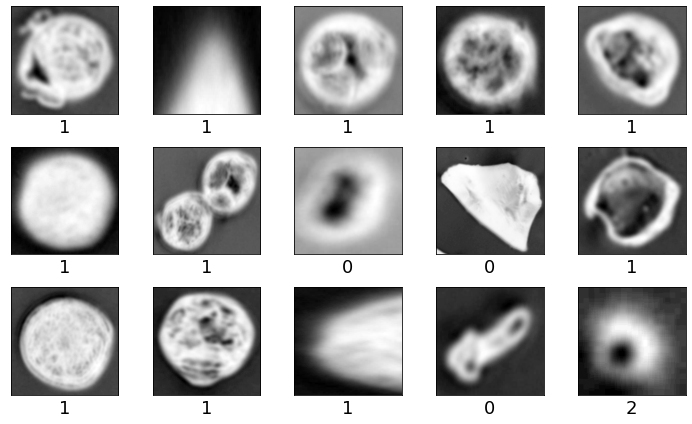

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))
for i in range(5):

    # train
    ax[0,i].imshow(train_images[i].reshape(img_rows, img_cols), cmap=plt.cm.binary)
    ax[0,i].set_xlabel(np.argmax(train_labels[i]), fontsize=18)
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([]); ax[0,i].grid(False)
    # val
    ax[1,i].imshow(val_images[i].reshape(img_rows, img_cols), cmap=plt.cm.binary)
    ax[1,i].set_xlabel(np.argmax(val_labels[i]), fontsize=18)
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([]); ax[1,i].grid(False)
    # test
    ax[2,i].imshow(test_images[i].reshape(img_rows, img_cols), cmap=plt.cm.binary)
    ax[2,i].set_xlabel(np.argmax(test_labels[i]), fontsize=18)
    ax[2,i].set_xticks([]); ax[2,i].set_yticks([]); ax[2,i].grid(False)
    
plt.tight_layout()
plt.show()

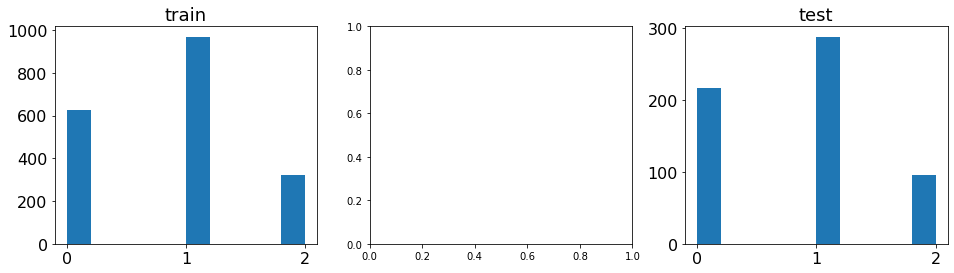

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].hist(np.argmax(train_labels, axis=1).flatten()); ax[0].set_title('train', fontsize=18); ax[0].set_xticks(np.arange(num_classes)); ax[0].tick_params(axis='both', which='major', labelsize=16);
# ax[1].hist(np.argmax(val_labels, axis=1).flatten()); ax[1].set_title('validation', fontsize=18); ax[1].set_xticks(np.arange(num_classes)); ax[1].tick_params(axis='both', which='major', labelsize=16);
ax[2].hist(np.argmax(test_labels, axis=1).flatten()); ax[2].set_title('test', fontsize=18); ax[2].set_xticks(np.arange(num_classes)); ax[2].tick_params(axis='both', which='major', labelsize=16);
plt.show()

### Create the CNN

In [9]:
model = Sequential()
# This layer creates a convolution kernel that is convolved with the layer input 
# to produce a tensor of outputs.
# When using this l
# Layer as the first layer in a model, provide the keyword argument
# input_shape
# Same in padding means zero padding evenly to left/right and up/down 
model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
# Downsamples the input along its spatial dimensions (height and width) by taking
# the maximum value over an input window (of size defined by pool_size) for each
# channel of the input. The window is shifted by strides along each dimension.
model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [19]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/15
30/30 [==============================] - 7s 218ms/step - loss: 0.4358 - categorical_accuracy: 0.8344 - val_loss: 0.4284 - val_categorical_accuracy: 0.8292
Epoch 2/15
30/30 [==============================] - 6s 194ms/step - loss: 0.4281 - categorical_accuracy: 0.8375 - val_loss: 0.4185 - val_categorical_accuracy: 0.8375
Epoch 3/15
30/30 [==============================] - 6s 190ms/step - loss: 0.4193 - categorical_accuracy: 0.8417 - val_loss: 0.4110 - val_categorical_accuracy: 0.8250
Epoch 4/15
30/30 [==============================] - 6s 191ms/step - loss: 0.4109 - categorical_accuracy: 0.8474 - val_loss: 0.4019 - val_categorical_accuracy: 0.8271
Epoch 5/15
30/30 [==============================] - 6s 191ms/step - loss: 0.4101 - categorical_accuracy: 0.8438 - val_loss: 0.3964 - val_categorical_accuracy: 0.8333
Epoch 6/15
30/30 [==============================] - 6s 192ms/step - loss: 0.3994 - categorical_accuracy: 0.8505 - val_loss: 0.3973 - val_categorical_accuracy: 0.8375
Epoc

### Evaluate training process

15/15 - 0s - loss: 0.3562 - categorical_accuracy: 0.8583


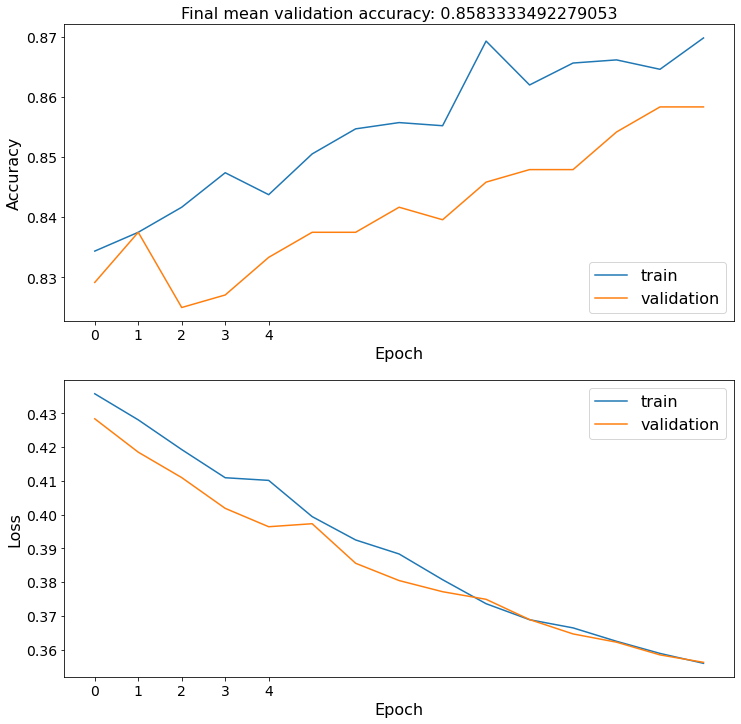

In [20]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

In [21]:
ypred_test = model.predict(test_images)
ypred_train = model.predict(train_images)

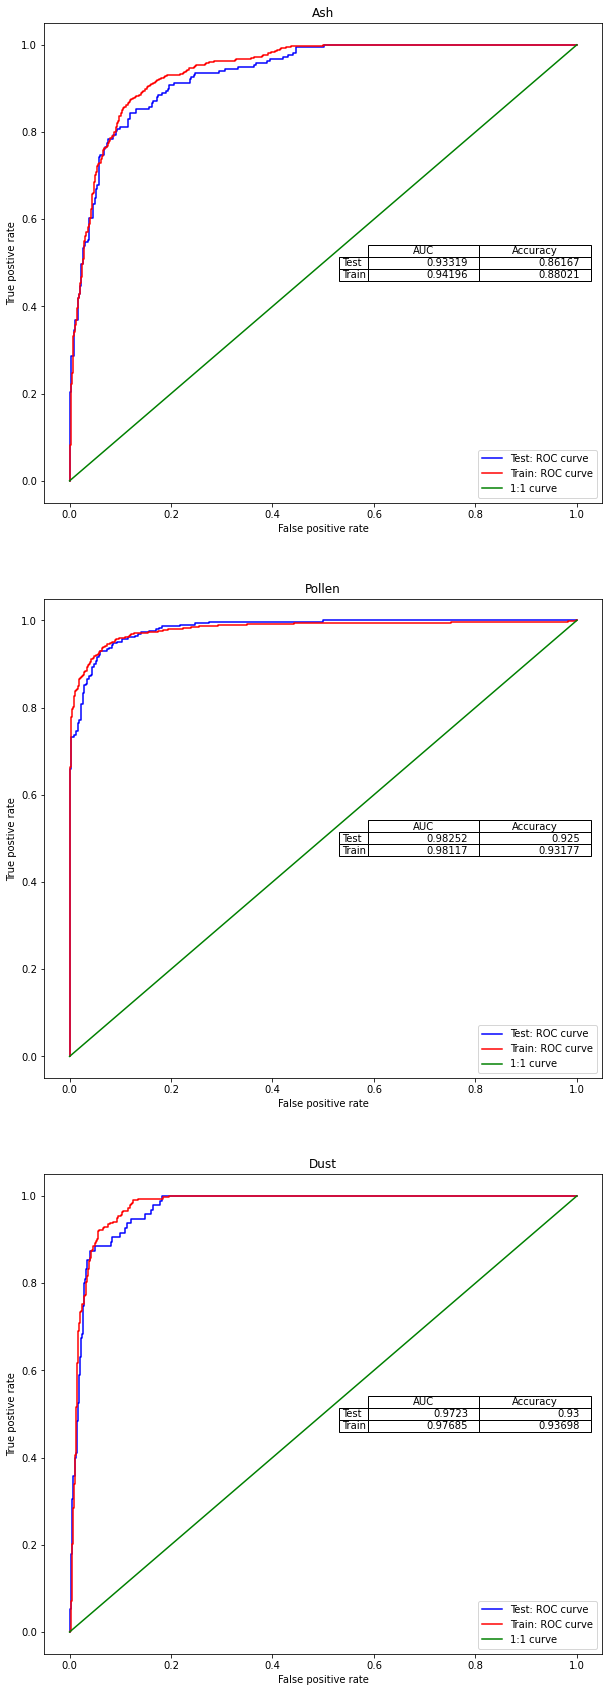

In [22]:
# Plotting the ROC curve, to test for overtaining and preformance
title = ['Ash','Pollen','Dust']
fig1, ax1 = plt.subplots(figsize=(10,30), nrows=3)

for i in range(num_classes):
    fpr,tpr, threshold =sklearn.metrics.roc_curve(test_labels[:,i],ypred_test[:,i])
    ax1[i].plot(fpr,tpr,'b', label='Test: ROC curve')

    fpr_train,tpr_train, threshold_train =sklearn.metrics.roc_curve(train_labels[:,i],ypred_train[:,i])
    ax1[i].plot(fpr_train,tpr_train,'r', label='Train: ROC curve')
    ax1[i].plot(np.linspace(0,1,100),np.linspace(0,1,100),'g', label='1:1 curve')
    ax1[i].set(xlabel='False positive rate',ylabel='True postive rate',title=title[i])
    ax1[i].legend()


    # The AUC and accuracy is computed and printed in the figure
    auc_score_train = auc(fpr_train,tpr_train)   
    auc_score_test = auc(fpr,tpr)   

    acc_score_train = accuracy_score(train_labels[:,i],np.where(ypred_train[:,i] > 0.5, 1, 0))
    acc_score_test = accuracy_score(test_labels[:,i],np.where(ypred_test[:,i] > 0.5, 1, 0))

    row_labels=['Test',
            'Train']
    table_vals=[[round(auc_score_test,5),round(acc_score_test,5)],
            [round(auc_score_train,5),round(acc_score_train,5)]]
    col_labels=['AUC','Accuracy']
    the_table = ax1[i].table(cellText=table_vals,
                  colWidths = [0.2]*3,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  loc='center right')

### Inference

In [23]:
conf_matrix = tf.math.confusion_matrix(labels=np.argmax(test_labels, axis=1),
                                       predictions=np.argmax(ypred_test, axis = 1),
                                       num_classes=num_classes)
print('Confusion Matrix: ', conf_matrix)

# Original code:
#sess = tf.compat.v1.InteractiveSession()
#conf_matrix = confusion.eval(session=sess)     # Needs update to new TF...
#sess.close()

# Accuracy score for inference
error_rate = (np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))) / np.sum(np.diag(conf_matrix))
inf_acc = 1-error_rate
print(error_rate)
print(inf_acc)

Confusion Matrix:  tf.Tensor(
[[185  18  14]
 [ 29 259   0]
 [ 21   0  74]], shape=(3, 3), dtype=int32)
0.1583011583011583
0.8416988416988417


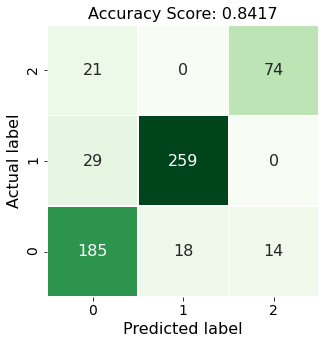

Correct: 518/600
Wrong: 82/600


In [24]:
plt.figure(figsize=(10,5))
ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, square=True, cbar=False, cmap='Greens')
ax.invert_yaxis()
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.title('Accuracy Score: {:.4f}'.format(inf_acc), fontsize=16)
plt.show()

print('Correct: {0}/{1}'.format(np.sum(np.diag(conf_matrix)),np.sum(conf_matrix)))
print('Wrong: {0}/{1}'.format((np.sum(conf_matrix)-np.sum(np.diag(conf_matrix))),np.sum(conf_matrix)))

### Inspection of predictions

##### Correctly predicted images

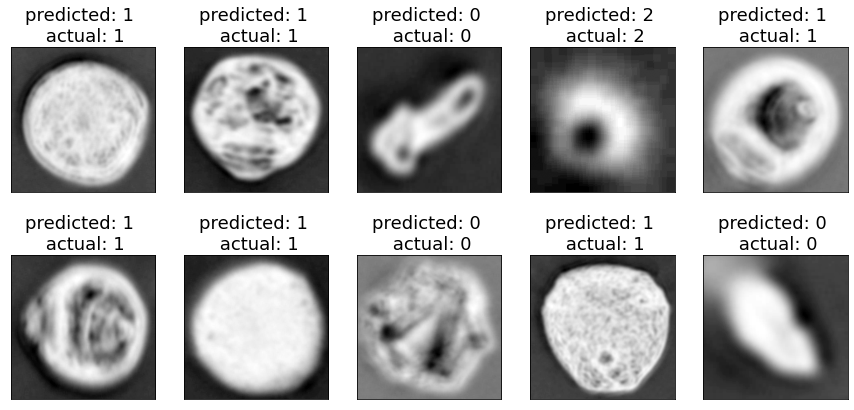

In [16]:
# show first 10 images that were correctly predicted
correct_idx = np.where(np.argmax(ypred_test, axis = 1) == np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(np.argmax(ypred_test, axis = 1)[correct_idx[i]], np.argmax(test_labels, axis=1)[correct_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

##### Wrongly predicted images

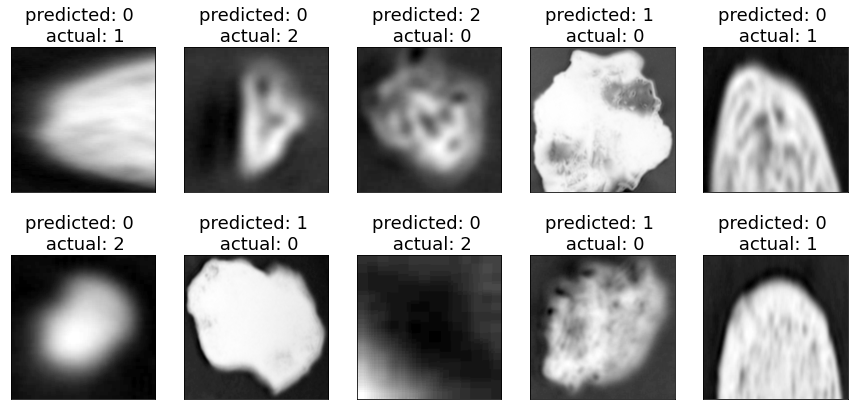

In [17]:
# Show first 10 images that were wrongly predicted:
wrong_idx = np.where(np.argmax(ypred_test, axis = 1) != np.argmax(test_labels, axis=1))[0]

fig, axs = plt.subplots(2,5, figsize=(15, 7))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(test_images[wrong_idx[i],:,:,0], cmap=plt.cm.binary)
    axs[i].set_title('predicted: {} \n actual: {}'.format(np.argmax(ypred_test, axis = 1)[wrong_idx[i]], np.argmax(test_labels, axis=1)[wrong_idx[i]]), fontsize=18)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)